##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-09-23 00:20:27.893074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 00:20:27.893110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 00:20:27.894020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 00:20:27.898950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 00:20:28.471330: W tensorflow/compiler/tf2

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
from dataclasses import dataclass

@dataclass(frozen=True)
class DatasetConfig:
    SEED_VALUE:  int = 41
    CUT_PLANE:   str = "coronal"
    HEIGHT: int = 350
    WIDTH: int = 400
         
    DATA_ROOT_TARGET:  str = f'/home/jovyan/data/pre-processed-autopet-min-{CUT_PLANE}' 
    DATA_ROOT_TRAIN:  str = DATA_ROOT_TARGET + '/Train' 
    DATA_ROOT_VALID:  str = DATA_ROOT_TARGET + '/Valid'
    DATA_ROOT_TEST:   str = DATA_ROOT_TARGET + '/Test'

In [6]:
train_dir = os.path.join(DatasetConfig.DATA_ROOT_TRAIN, '')
validation_dir = os.path.join(DatasetConfig.DATA_ROOT_VALID, '')
test_dir = os.path.join(DatasetConfig.DATA_ROOT_TEST, '')

BATCH_SIZE = 32
IMG_SIZE = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 722 files belonging to 2 classes.


2024-09-23 00:22:11.663786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 00:22:11.686745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-23 00:22:11.686888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 80 files belonging to 2 classes.


Show the first nine images and labels from the training set:

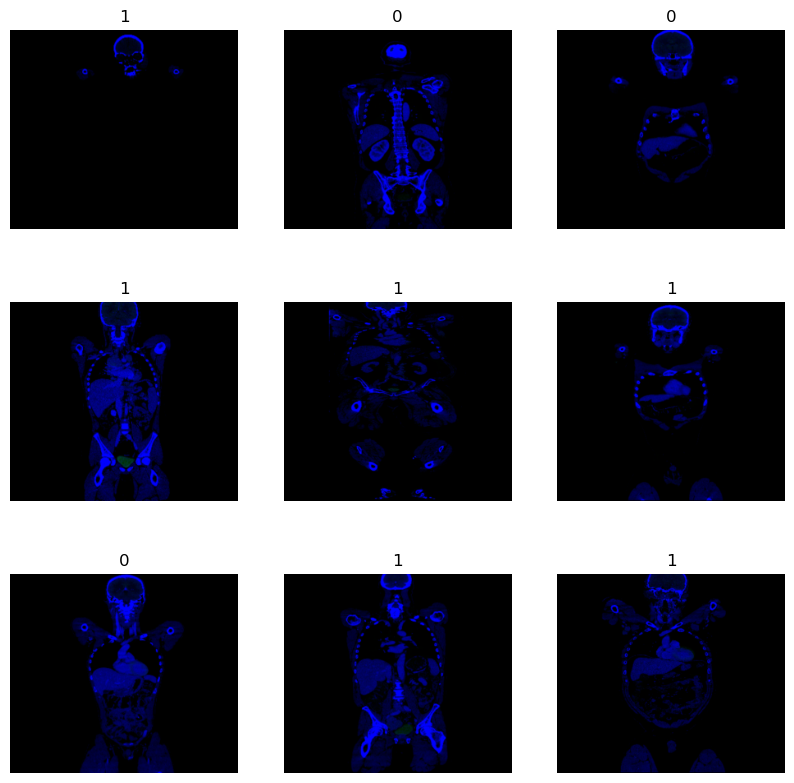

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

In [12]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [14]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
# tf.keras.applications.densenet.DenseNet201
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

74836368/74836368 [==============================] - 3s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-09-23 00:27:35.596956: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


(32, 11, 12, 1920)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [18]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350, 400, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 356, 406, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 175, 200, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 175, 200, 64)         256       ['conv1/conv[0][0]']

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [21]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [29]:
inputs = tf.keras.Input(shape=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 400, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 350, 400, 3)       0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 350, 400, 3)       0         
 da)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 350, 400, 3)       0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 11, 12, 1920)      18321984  
                                                           

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [31]:
len(model.trainable_variables)

2

In [32]:
# !pip install pydot

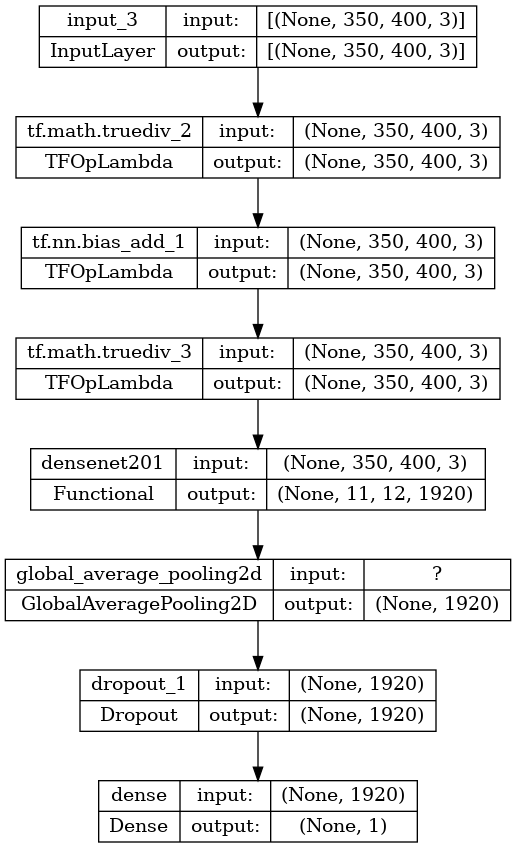

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [35]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 3s 178ms/step - loss: 0.8728 - accuracy: 0.5000


In [36]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.50


In [37]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
 1/23 [>.............................] - ETA: 3:16 - loss: 0.8956 - accuracy: 0.4375

2024-09-23 00:31:43.613210: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc1ec372070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-23 00:31:43.613243: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-09-23 00:31:43.620085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727051503.703186  500558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 [==============================] - 11s 96ms/step - loss: 0.7949 - accuracy: 0.4986 - val_loss: 0.7108 - val_accuracy: 0.5125
Epoch 2/50
23/23 [==============================] - 2s 88ms/step - loss: 0.7143 - accuracy: 0.4958 - val_loss: 0.6846 - val_accuracy: 0.5250
Epoch 3/50
23/23 [==============================] - 2s 88ms/step - loss: 0.7007 - accuracy: 0.5125 - val_loss: 0.6841 - val_accuracy: 0.5500
Epoch 4/50
23/23 [==============================] - 2s 86ms/step - loss: 0.6945 - accuracy: 0.5499 - val_loss: 0.6832 - val_accuracy: 0.5250
Epoch 5/50
23/23 [==============================] - 2s 86ms/step - loss: 0.7134 - accuracy: 0.5111 - val_loss: 0.6826 - val_accuracy: 0.5375
Epoch 6/50
23/23 [==============================] - 2s 86ms/step - loss: 0.7087 - accuracy: 0.5014 - val_loss: 0.6817 - val_accuracy: 0.5375
Epoch 7/50
23/23 [==============================] - 2s 87ms/step - loss: 0.7065 - accuracy: 0.5222 - val_loss: 0.6810 - val_accuracy: 0.5500
Epoch 8/50
23/23 [=====

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5905 - loss: 0.7091

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5919 - loss: 0.7077

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5932 - loss: 0.7063

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5945 - loss: 0.7048

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5959 - loss: 0.7032

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5972 - loss: 0.7018

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5985 - loss: 0.7003

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5997 - loss: 0.6990

W0000 00:00:1723777704.397737  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.398671  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.399497  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.400322  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.401154  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.402015  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.402938  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.403723  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.404513  124620 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6008 - loss: 0.6978

W0000 00:00:1723777704.599494  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.600166  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.600837  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.601515  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.602177  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.602866  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.603530  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.604222  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.604885  124620 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6013 - loss: 0.6973 - val_accuracy: 0.8292 - val_loss: 0.4765


Epoch 2/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5625 - loss: 0.6844

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5764 - loss: 0.7090

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6243 - loss: 0.6747

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6466 - loss: 0.6556

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6565 - loss: 0.6434

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6626 - loss: 0.6359

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6684 - loss: 0.6293

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6735 - loss: 0.6235

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6778 - loss: 0.6178

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6815 - loss: 0.6123

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6845 - loss: 0.6075

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6874 - loss: 0.6027

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6905 - loss: 0.5979

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6933 - loss: 0.5936

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6959 - loss: 0.5898

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6984 - loss: 0.5865

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7007 - loss: 0.5833

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7030 - loss: 0.5803

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7052 - loss: 0.5774

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7071 - loss: 0.5748

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7089 - loss: 0.5724

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7106 - loss: 0.5702

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7122 - loss: 0.5681

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7138 - loss: 0.5661

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7152 - loss: 0.5642

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7165 - loss: 0.5624

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7177 - loss: 0.5607

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7189 - loss: 0.5591

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7201 - loss: 0.5575

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7212 - loss: 0.5560

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7221 - loss: 0.5546

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7236 - loss: 0.5526 - val_accuracy: 0.9047 - val_loss: 0.3534


Epoch 3/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7500 - loss: 0.4450

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7604 - loss: 0.4616

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7663 - loss: 0.4636

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7692 - loss: 0.4634

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7739 - loss: 0.4611

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7761 - loss: 0.4616

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7772 - loss: 0.4624

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7778 - loss: 0.4624

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7779 - loss: 0.4620

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7780 - loss: 0.4616

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7785 - loss: 0.4612

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7793 - loss: 0.4603

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7801 - loss: 0.4593

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7806 - loss: 0.4585

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7814 - loss: 0.4573

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7819 - loss: 0.4564

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7823 - loss: 0.4556

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7828 - loss: 0.4549

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7832 - loss: 0.4543

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7836 - loss: 0.4537

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7840 - loss: 0.4531

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7844 - loss: 0.4526

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7848 - loss: 0.4521

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7853 - loss: 0.4516

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7858 - loss: 0.4511

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7864 - loss: 0.4504

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7870 - loss: 0.4497

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7876 - loss: 0.4491

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7883 - loss: 0.4485

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7888 - loss: 0.4478

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7894 - loss: 0.4472

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7903 - loss: 0.4462 - val_accuracy: 0.9282 - val_loss: 0.2795


Epoch 4/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8125 - loss: 0.3939

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8403 - loss: 0.3769

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8523 - loss: 0.3685

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8546 - loss: 0.3655

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8576 - loss: 0.3630

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8586 - loss: 0.3606

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8590 - loss: 0.3587

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8587 - loss: 0.3582

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8584 - loss: 0.3579

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8576 - loss: 0.3581

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8577 - loss: 0.3580

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8577 - loss: 0.3579

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8579 - loss: 0.3578

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8582 - loss: 0.3579

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8581 - loss: 0.3582

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8581 - loss: 0.3584

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8579 - loss: 0.3585

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8576 - loss: 0.3587

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8574 - loss: 0.3588

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8573 - loss: 0.3587

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8572 - loss: 0.3587

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8572 - loss: 0.3588

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8569 - loss: 0.3590

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8566 - loss: 0.3591

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8564 - loss: 0.3592

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8562 - loss: 0.3592

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8562 - loss: 0.3591

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3589

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3587

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3585

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3585

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8562 - loss: 0.3583 - val_accuracy: 0.9443 - val_loss: 0.2279


Epoch 5/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9062 - loss: 0.3328

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9097 - loss: 0.3131

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9124 - loss: 0.3047

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9052 - loss: 0.3056

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8997 - loss: 0.3112

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8960 - loss: 0.3150

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8939 - loss: 0.3175

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8930 - loss: 0.3186

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8917 - loss: 0.3189

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8909 - loss: 0.3184

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8910 - loss: 0.3174

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8910 - loss: 0.3169

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8911 - loss: 0.3162

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8911 - loss: 0.3159

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8912 - loss: 0.3155

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8913 - loss: 0.3148

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8916 - loss: 0.3143

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3140

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3139

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3138

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3136

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8918 - loss: 0.3135

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8918 - loss: 0.3133

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3132

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8915 - loss: 0.3131

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8913 - loss: 0.3131

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8911 - loss: 0.3131

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8909 - loss: 0.3130

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8907 - loss: 0.3128

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8906 - loss: 0.3127

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8904 - loss: 0.3128

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8901 - loss: 0.3128 - val_accuracy: 0.9554 - val_loss: 0.1954


Epoch 6/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9375 - loss: 0.2704

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8889 - loss: 0.3159

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8805 - loss: 0.3255

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8699 - loss: 0.3332

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8653 - loss: 0.3360

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8633 - loss: 0.3365

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8628 - loss: 0.3352

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8637 - loss: 0.3324

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8653 - loss: 0.3291

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8670 - loss: 0.3260

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8685 - loss: 0.3233

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8698 - loss: 0.3211

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8707 - loss: 0.3190

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8716 - loss: 0.3170

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8727 - loss: 0.3149

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8737 - loss: 0.3130

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8747 - loss: 0.3112

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8758 - loss: 0.3095

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8768 - loss: 0.3078

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8779 - loss: 0.3062

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8790 - loss: 0.3046

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8801 - loss: 0.3031

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8810 - loss: 0.3019

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8818 - loss: 0.3007

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8825 - loss: 0.2997

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8832 - loss: 0.2988

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8837 - loss: 0.2980

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8842 - loss: 0.2972

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8847 - loss: 0.2964

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8852 - loss: 0.2956

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8856 - loss: 0.2949

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8862 - loss: 0.2941 - val_accuracy: 0.9567 - val_loss: 0.1724


Epoch 7/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9062 - loss: 0.3483

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9306 - loss: 0.2985

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9265 - loss: 0.2989

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9228 - loss: 0.2965

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9203 - loss: 0.2938

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9195 - loss: 0.2905

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9170 - loss: 0.2895

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9159 - loss: 0.2881

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9156 - loss: 0.2859

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9157 - loss: 0.2835

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9158 - loss: 0.2812

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9157 - loss: 0.2793

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9153 - loss: 0.2781

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9150 - loss: 0.2769

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9149 - loss: 0.2755

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9150 - loss: 0.2739

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9149 - loss: 0.2728

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9145 - loss: 0.2723

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9141 - loss: 0.2718

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9138 - loss: 0.2714

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9136 - loss: 0.2709

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9133 - loss: 0.2704

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9131 - loss: 0.2700

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9130 - loss: 0.2696

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9127 - loss: 0.2693

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9123 - loss: 0.2691

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9121 - loss: 0.2689

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9118 - loss: 0.2687

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9116 - loss: 0.2685

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9114 - loss: 0.2682

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9111 - loss: 0.2681

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9106 - loss: 0.2680 - val_accuracy: 0.9604 - val_loss: 0.1556


Epoch 8/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8750 - loss: 0.2662

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8698 - loss: 0.2745

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8759 - loss: 0.2721

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8805 - loss: 0.2695

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8825 - loss: 0.2680

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8830 - loss: 0.2676

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8839 - loss: 0.2674

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8854 - loss: 0.2662

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8875 - loss: 0.2641

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8899 - loss: 0.2618

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8920 - loss: 0.2594

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8939 - loss: 0.2575

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8959 - loss: 0.2556

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8978 - loss: 0.2537

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8994 - loss: 0.2520

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9009 - loss: 0.2506

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9023 - loss: 0.2493

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9033 - loss: 0.2483

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9039 - loss: 0.2479

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9043 - loss: 0.2477

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9046 - loss: 0.2475

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2476

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2476

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2478

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2481

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2484

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2487

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2489

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2490

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9049 - loss: 0.2490

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9049 - loss: 0.2491

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9050 - loss: 0.2492 - val_accuracy: 0.9604 - val_loss: 0.1435


Epoch 9/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9375 - loss: 0.1943

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9201 - loss: 0.2273

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9230 - loss: 0.2254

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9258 - loss: 0.2193

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9268 - loss: 0.2178

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9271 - loss: 0.2172

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9276 - loss: 0.2160

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9275 - loss: 0.2146

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9273 - loss: 0.2138

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9271 - loss: 0.2132

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9266 - loss: 0.2135

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9262 - loss: 0.2142

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9259 - loss: 0.2147

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9257 - loss: 0.2150

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9256 - loss: 0.2153

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9254 - loss: 0.2157

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9251 - loss: 0.2161

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9247 - loss: 0.2166

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9244 - loss: 0.2170

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9242 - loss: 0.2172

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9240 - loss: 0.2175

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9239 - loss: 0.2177

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9236 - loss: 0.2181

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9233 - loss: 0.2185

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9230 - loss: 0.2190

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9227 - loss: 0.2194

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9223 - loss: 0.2199

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9220 - loss: 0.2203

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9218 - loss: 0.2206

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9216 - loss: 0.2209

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9214 - loss: 0.2212

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9211 - loss: 0.2216 - val_accuracy: 0.9641 - val_loss: 0.1348


Epoch 10/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9688 - loss: 0.2103

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9358 - loss: 0.2372

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9349 - loss: 0.2312

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9322 - loss: 0.2284

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9318 - loss: 0.2240

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9312 - loss: 0.2210

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9303 - loss: 0.2193

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9296 - loss: 0.2181

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9294 - loss: 0.2168

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9293 - loss: 0.2157

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9294 - loss: 0.2147

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9293 - loss: 0.2143

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9292 - loss: 0.2142

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9290 - loss: 0.2143

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9288 - loss: 0.2145

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9287 - loss: 0.2146

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9285 - loss: 0.2146

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9285 - loss: 0.2145

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9283 - loss: 0.2145

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9282 - loss: 0.2146

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9280 - loss: 0.2149

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9278 - loss: 0.2150

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9276 - loss: 0.2151

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9274 - loss: 0.2154

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9272 - loss: 0.2157

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9269 - loss: 0.2159

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9267 - loss: 0.2161

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9265 - loss: 0.2163

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9263 - loss: 0.2165

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9260 - loss: 0.2168

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9258 - loss: 0.2170

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9256 - loss: 0.2171 - val_accuracy: 0.9653 - val_loss: 0.1308


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

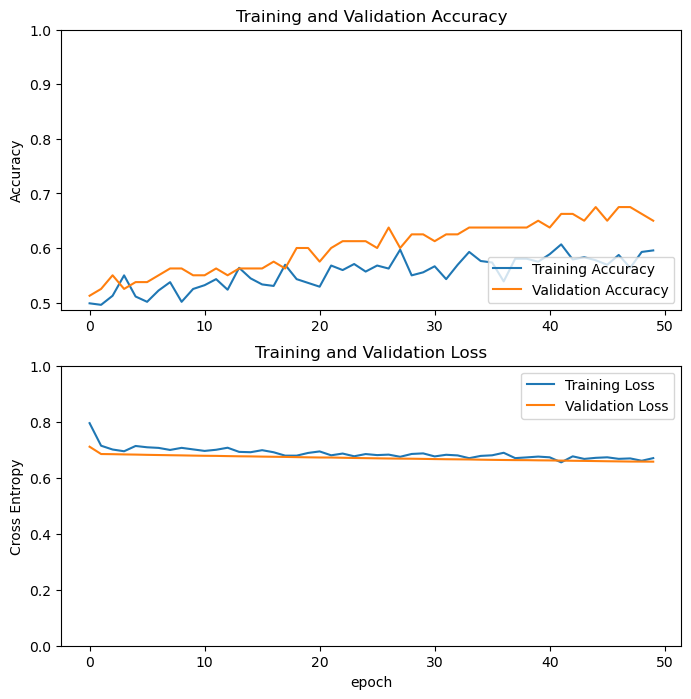

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [39]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  707


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350, 400, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 350, 400, 3)       0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 350, 400, 3)       0         
 da)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 350, 400, 3)       0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 11, 12, 1920)      18321984  
                                                           

In [43]:
len(model.trainable_variables)

521

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [48]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 51/100
22/23 [===========================>..] - ETA: 0s - loss: 6.3829e-04 - accuracy: 1.0000

KeyboardInterrupt: 

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7755 - loss: 0.4538

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7757 - loss: 0.4529

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7761 - loss: 0.4518

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7766 - loss: 0.4507

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7770 - loss: 0.4497

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7775 - loss: 0.4486

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7780 - loss: 0.4475

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7786 - loss: 0.4464

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7789 - loss: 0.4459

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7795 - loss: 0.4448

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7801 - loss: 0.4436

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7804 - loss: 0.4431

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7810 - loss: 0.4420

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7818 - loss: 0.4408

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7825 - loss: 0.4395

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7829 - loss: 0.4388

W0000 00:00:1723777740.759928  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.761018  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.762009  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.763008  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.763868  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.764730  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.765679  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.766639  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.767538  124620 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.7833 - loss: 0.4382 - val_accuracy: 0.9740 - val_loss: 0.0901


Epoch 12/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8750 - loss: 0.2900

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8819 - loss: 0.2776

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8860 - loss: 0.2764

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8862 - loss: 0.2743

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8872 - loss: 0.2727

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8858 - loss: 0.2743

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8847 - loss: 0.2745

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8845 - loss: 0.2745

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8838 - loss: 0.2754

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8832 - loss: 0.2763

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8831 - loss: 0.2766

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8832 - loss: 0.2765

22/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8836 - loss: 0.2763

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8838 - loss: 0.2762

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8840 - loss: 0.2762

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8841 - loss: 0.2763

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8842 - loss: 0.2762

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8845 - loss: 0.2759

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8846 - loss: 0.2759

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8843 - loss: 0.2764

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8842 - loss: 0.2765

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8840 - loss: 0.2767

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8839 - loss: 0.2767

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8839 - loss: 0.2765

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8840 - loss: 0.2763

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8841 - loss: 0.2761

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8842 - loss: 0.2757

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8844 - loss: 0.2754

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8845 - loss: 0.2753

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8847 - loss: 0.2749

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8849 - loss: 0.2747

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8850 - loss: 0.2743

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8851 - loss: 0.2740

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8852 - loss: 0.2737

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8853 - loss: 0.2735

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8853 - loss: 0.2733 - val_accuracy: 0.9715 - val_loss: 0.0812


Epoch 13/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9062 - loss: 0.2526

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.2120

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9519 - loss: 0.1942

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9485 - loss: 0.1909

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9445 - loss: 0.1894

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9387 - loss: 0.1916

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9344 - loss: 0.1945

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9327 - loss: 0.1958

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9308 - loss: 0.1974

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9289 - loss: 0.1994

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9280 - loss: 0.2005

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9265 - loss: 0.2023

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9253 - loss: 0.2038

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9248 - loss: 0.2044

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9238 - loss: 0.2055

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9229 - loss: 0.2065

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9221 - loss: 0.2073

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9218 - loss: 0.2076

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9213 - loss: 0.2081

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9207 - loss: 0.2089

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9203 - loss: 0.2093

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9198 - loss: 0.2102

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9192 - loss: 0.2110

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9188 - loss: 0.2114

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9183 - loss: 0.2121

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9178 - loss: 0.2127

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9175 - loss: 0.2133

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9172 - loss: 0.2136

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9169 - loss: 0.2141

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9166 - loss: 0.2146

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9165 - loss: 0.2149

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9162 - loss: 0.2154

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9160 - loss: 0.2158

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2161

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2163

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9156 - loss: 0.2165

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9156 - loss: 0.2167 - val_accuracy: 0.9777 - val_loss: 0.0656


Epoch 14/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 1.0000 - loss: 0.0997

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9766 - loss: 0.1141

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9681 - loss: 0.1321

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9657 - loss: 0.1380

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9584 - loss: 0.1468

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9510 - loss: 0.1533

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9463 - loss: 0.1575

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9450 - loss: 0.1587

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9434 - loss: 0.1597

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.1605

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9419 - loss: 0.1613

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9412 - loss: 0.1623

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9408 - loss: 0.1632

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9403 - loss: 0.1641

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9397 - loss: 0.1650

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9394 - loss: 0.1654

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9390 - loss: 0.1662

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9388 - loss: 0.1667

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9387 - loss: 0.1669

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9384 - loss: 0.1676

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9382 - loss: 0.1679

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9379 - loss: 0.1687

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9376 - loss: 0.1694

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9374 - loss: 0.1702

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9371 - loss: 0.1709

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9370 - loss: 0.1713

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9368 - loss: 0.1720

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9366 - loss: 0.1725

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9365 - loss: 0.1728

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1730

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1733

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1735

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9362 - loss: 0.1738

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9361 - loss: 0.1741

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9360 - loss: 0.1742

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9359 - loss: 0.1746

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9357 - loss: 0.1749

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9356 - loss: 0.1752

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9355 - loss: 0.1753 - val_accuracy: 0.9790 - val_loss: 0.0592


Epoch 15/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9688 - loss: 0.1888

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9514 - loss: 0.1675

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9483 - loss: 0.1590

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9491 - loss: 0.1550

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9507 - loss: 0.1513

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9514 - loss: 0.1477

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9513 - loss: 0.1464

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9513 - loss: 0.1447

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9493 - loss: 0.1469

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9483 - loss: 0.1485

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9459 - loss: 0.1516

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9439 - loss: 0.1537

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9426 - loss: 0.1551

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9422 - loss: 0.1554

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9417 - loss: 0.1559

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9409 - loss: 0.1567

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9407 - loss: 0.1570

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9404 - loss: 0.1575

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9400 - loss: 0.1583

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9398 - loss: 0.1586

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1591

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1593

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1596

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1603

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9386 - loss: 0.1606

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1610

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9382 - loss: 0.1617

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9381 - loss: 0.1620

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9380 - loss: 0.1625

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9379 - loss: 0.1628

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9377 - loss: 0.1632

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9377 - loss: 0.1634

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9376 - loss: 0.1637

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9374 - loss: 0.1640

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9372 - loss: 0.1644

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9371 - loss: 0.1646

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9370 - loss: 0.1648

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9368 - loss: 0.1651

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9366 - loss: 0.1652

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1655

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1657

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9362 - loss: 0.1658 - val_accuracy: 0.9802 - val_loss: 0.0545


Epoch 16/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.1078

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9609 - loss: 0.1243

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9434 - loss: 0.1378

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9384 - loss: 0.1418

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9374 - loss: 0.1417

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9364 - loss: 0.1415

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9357 - loss: 0.1426

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9350 - loss: 0.1451

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9350 - loss: 0.1461

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9354 - loss: 0.1464

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9359 - loss: 0.1468

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9364 - loss: 0.1466

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9369 - loss: 0.1462

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9379 - loss: 0.1454

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9381 - loss: 0.1454

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9381 - loss: 0.1455

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1453

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1454

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1454

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9390 - loss: 0.1454

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1454

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1454

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1454

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1454

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1455

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1456

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1456

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1457

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1458

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1458

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1458

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1459

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9393 - loss: 0.1459 - val_accuracy: 0.9851 - val_loss: 0.0497


Epoch 17/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8750 - loss: 0.1786

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8906 - loss: 0.1586

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9028 - loss: 0.1517

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9095 - loss: 0.1488

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9159 - loss: 0.1470

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9202 - loss: 0.1443

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9222 - loss: 0.1436

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9234 - loss: 0.1432

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9247 - loss: 0.1426

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9257 - loss: 0.1418

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9276 - loss: 0.1412

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9296 - loss: 0.1404

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9307 - loss: 0.1397

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9318 - loss: 0.1391

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9330 - loss: 0.1384

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9341 - loss: 0.1377

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9359 - loss: 0.1364

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9366 - loss: 0.1360

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9373 - loss: 0.1357

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9379 - loss: 0.1353

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1350

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1346

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9396 - loss: 0.1342

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9406 - loss: 0.1337

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9410 - loss: 0.1336

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9413 - loss: 0.1335

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9420 - loss: 0.1333

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9423 - loss: 0.1332

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9426 - loss: 0.1330

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9429 - loss: 0.1329

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9431 - loss: 0.1327

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9434 - loss: 0.1325

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9436 - loss: 0.1324

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9440 - loss: 0.1323

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9442 - loss: 0.1322

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9444 - loss: 0.1322

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9446 - loss: 0.1321

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9448 - loss: 0.1321

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9449 - loss: 0.1321

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9451 - loss: 0.1321

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9452 - loss: 0.1322

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9454 - loss: 0.1322

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9455 - loss: 0.1322

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9456 - loss: 0.1323

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9459 - loss: 0.1323

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9460 - loss: 0.1324

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9461 - loss: 0.1324

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9463 - loss: 0.1324

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.1324

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.1324

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9467 - loss: 0.1325

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9468 - loss: 0.1325 - val_accuracy: 0.9814 - val_loss: 0.0517


Epoch 18/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.1182

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9609 - loss: 0.1178

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1092

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9563 - loss: 0.1049

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9555 - loss: 0.1054

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1049

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9552 - loss: 0.1050

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9553 - loss: 0.1050

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9555 - loss: 0.1047

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1043

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9558 - loss: 0.1044

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9559 - loss: 0.1047

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9561 - loss: 0.1048

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9563 - loss: 0.1048

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9564 - loss: 0.1049

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9563 - loss: 0.1056

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1066

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1073

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1078

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1084

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9561 - loss: 0.1090

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9561 - loss: 0.1095

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9561 - loss: 0.1099

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9560 - loss: 0.1105

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9558 - loss: 0.1110

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9557 - loss: 0.1114

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9556 - loss: 0.1119

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9555 - loss: 0.1122

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9554 - loss: 0.1124

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9554 - loss: 0.1126

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1127

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1129

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1131

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9552 - loss: 0.1133

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9552 - loss: 0.1133

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9551 - loss: 0.1135

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9551 - loss: 0.1136

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9550 - loss: 0.1137

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1138

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1140

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1141

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1142

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1143

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1145

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1146

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1147

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1147

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1148

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1149

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1150

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1151

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9549 - loss: 0.1152

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9549 - loss: 0.1154 - val_accuracy: 0.9889 - val_loss: 0.0417


Epoch 19/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9062 - loss: 0.1450

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9219 - loss: 0.1286

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9340 - loss: 0.1224

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9368 - loss: 0.1214

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9407 - loss: 0.1175

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9437 - loss: 0.1139

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9460 - loss: 0.1114

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9502 - loss: 0.1066

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9521 - loss: 0.1043

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9533 - loss: 0.1032

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9540 - loss: 0.1027

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9545 - loss: 0.1025

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9551 - loss: 0.1026

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9556 - loss: 0.1027

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1027

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9564 - loss: 0.1031

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9567 - loss: 0.1033

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9569 - loss: 0.1035

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1037

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1043

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1048

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1053

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9572 - loss: 0.1056

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9573 - loss: 0.1058

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9573 - loss: 0.1059

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9575 - loss: 0.1060

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9576 - loss: 0.1060

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9577 - loss: 0.1060

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9578 - loss: 0.1061

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1061

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9580 - loss: 0.1061

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1061

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1062

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1063

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1065

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1067

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9580 - loss: 0.1068

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1070

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1072

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9578 - loss: 0.1075

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9576 - loss: 0.1078

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9575 - loss: 0.1081

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9575 - loss: 0.1084

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1086

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1087

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1089

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1090

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1091

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1092

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1093

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1094

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1095

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1096

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1097

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1098

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1098

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9571 - loss: 0.1099

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9571 - loss: 0.1101

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9570 - loss: 0.1103

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9569 - loss: 0.1105 - val_accuracy: 0.9851 - val_loss: 0.0428


Epoch 20/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9375 - loss: 0.1219

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9297 - loss: 0.1449

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9323 - loss: 0.1463

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9355 - loss: 0.1420

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9384 - loss: 0.1372

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9400 - loss: 0.1340

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9409 - loss: 0.1320

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9410 - loss: 0.1324

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9418 - loss: 0.1318

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9429 - loss: 0.1307

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9440 - loss: 0.1299

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9443 - loss: 0.1298

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9447 - loss: 0.1295

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9453 - loss: 0.1289

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9456 - loss: 0.1286

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9461 - loss: 0.1279

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9463 - loss: 0.1274

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9467 - loss: 0.1268

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9471 - loss: 0.1263

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9474 - loss: 0.1259

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9477 - loss: 0.1254

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9480 - loss: 0.1251

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9483 - loss: 0.1249

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9485 - loss: 0.1247

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9487 - loss: 0.1244

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9489 - loss: 0.1242

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9491 - loss: 0.1241

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9492 - loss: 0.1239

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9494 - loss: 0.1237

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9495 - loss: 0.1235

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9497 - loss: 0.1233

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9499 - loss: 0.1231

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9501 - loss: 0.1229

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9502 - loss: 0.1226

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9504 - loss: 0.1224

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9506 - loss: 0.1222

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9507 - loss: 0.1220

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1219

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1218

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1218

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1219

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1220

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1221

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1221

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1222

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1222

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1224

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1226

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1227

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1229

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1230

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9505 - loss: 0.1232

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9504 - loss: 0.1233

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1235

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1236

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9501 - loss: 0.1239

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9500 - loss: 0.1241

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9499 - loss: 0.1243 - val_accuracy: 0.9876 - val_loss: 0.0355


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

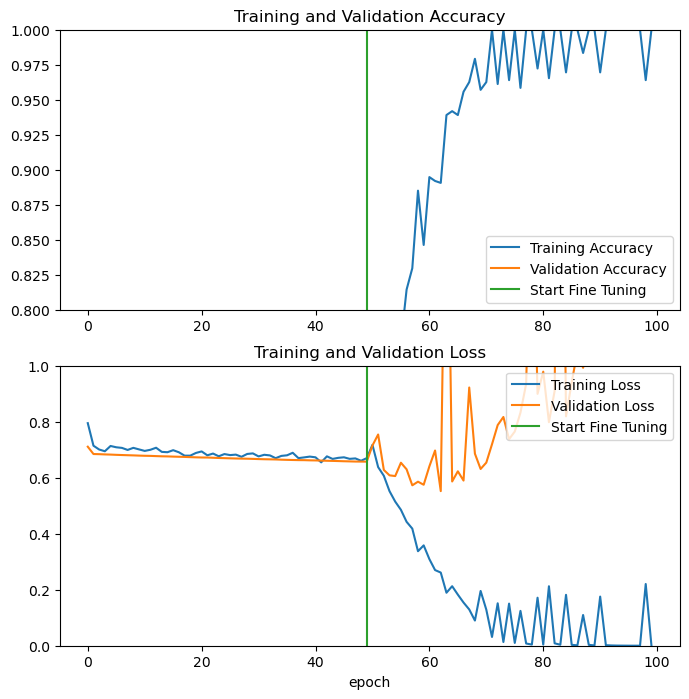

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [49]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 1s 65ms/step - loss: 1.9296 - accuracy: 0.6050
Test accuracy : 0.6050000190734863


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1]
Labels:
 [0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1]


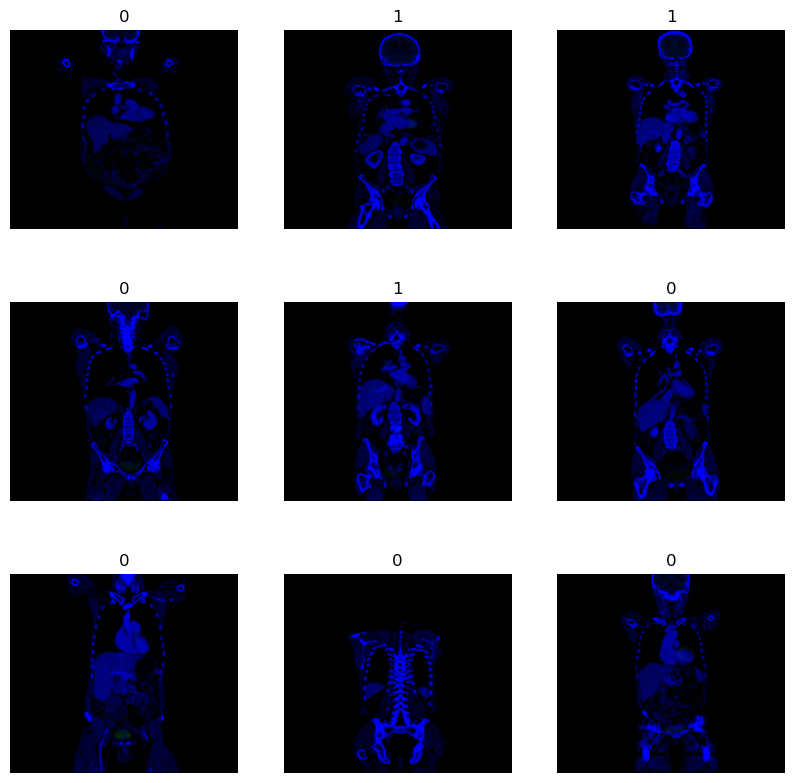

In [50]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")